# New Clue
In this notebook, we'll test the new, simplified CLUE implementation. We're not using Bayesian Neural Networks here, so the uncertainty is just the entropy of the classifier.

## Setup


Import libraries

In [16]:
import importlib
import models.regene_models as regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import clue.new_CLUE as new_CLUE
importlib.reload(new_CLUE)

<module 'clue.new_CLUE' from '/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/clue/new_CLUE.py'>

Set the device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


Load the Datasets

In [4]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Set the latent dimension

In [5]:
latent_dim = 256

Create a models directory if it doesn't exist

In [8]:
# Create models directory if it doesn't exist
os.makedirs('../model_saves', exist_ok=True)
model_saves_dir = '../model_saves'

## Testing CLUE on joint-training autoencoder
We'll first test the CLUE implementation on the joint-training autoencoder. That is, the classifier and decoder are trained jointly, with a loss function that combines the reconstruction loss and the classification loss. No generative regularisation is used here, unlike the SVAE.

### Load the joint-training autoencoder

We load the model trained with a joint training objective.

In [9]:
classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)

# Load the trained models
classifier.load_state_dict(torch.load(os.path.join(model_saves_dir, 'joint_classifier.pth'), map_location=device))
decoder.load_state_dict(torch.load(os.path.join(model_saves_dir, 'joint_decoder.pth'), map_location=device))


/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_13985/1277527420.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(os.path

<All keys matched successfully>

Get the most uncertain images, we need a non-shuffled loader for this.

In [23]:
# Create a non-shuffled loader for uncertainty calculation
eval_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Get uncertainty scores for all test set data points
uncertainties = []
indices = []

classifier.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        # Get latent representations and predictions
        z, logits = classifier(images)
        
        # Calculate uncertainty (entropy) for each prediction
        probs = torch.nn.functional.softmax(logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        
        # Store uncertainties and indices
        uncertainties.extend(entropy.cpu().numpy())
        indices.extend(range(i*eval_loader.batch_size, min((i+1)*eval_loader.batch_size, len(testset))))

# Convert to numpy arrays
uncertainties = np.array(uncertainties)
indices = np.array(indices)

# Sort by uncertainty (descending order)
sorted_idx = np.argsort(-uncertainties)
sorted_uncertainties = uncertainties[sorted_idx]
sorted_data_indices = indices[sorted_idx]

We then plot the plot the most uncertain predictions on the test set.

In [12]:
import matplotlib.pyplot as plt
import torch

def plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=5):
    """
    Plots the top-n most uncertain predictions from the training set.

    Args:
        testset (torch.utils.data.Dataset): Dataset that returns (image, label) samples.
        sorted_data_indices (np.ndarray): Array of indices sorted in descending order by uncertainty.
        sorted_uncertainties (np.ndarray): Array of uncertainty (entropy) values, sorted to match sorted_data_indices.
        n_plot (int): Number of images to plot.
    """
    # Calculate number of rows needed
    images_per_row = 10
    n_rows = (n_plot - 1) // images_per_row + 1
    
    plt.figure(figsize=(15, 3 * n_rows))
    for i in range(n_plot):
        data_idx = sorted_data_indices[i]
        image, _ = testset[data_idx]
        
        # If image is a torch.Tensor, convert it to a NumPy array.
        if torch.is_tensor(image):
            image = image.cpu().detach().numpy()
            # If the image has one channel [1, H, W], squeeze out the channel dimension.
            if image.ndim == 3 and image.shape[0] == 1:
                image = image.squeeze(0)
        
        row = i // images_per_row
        col = i % images_per_row
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Entropy: {sorted_uncertainties[i]:.2f}")
        plt.axis("off")
    
    plt.suptitle("Most Uncertain Predictions")
    plt.show()

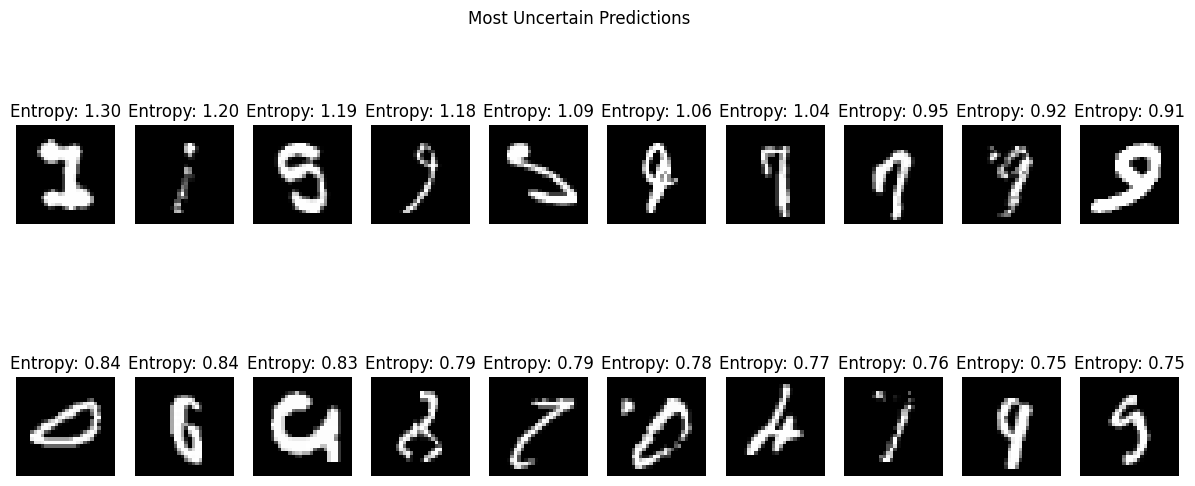

In [13]:
# Plot the most uncertain predictions
plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=20)

### Test new CLUE implementation

Now we test the "new" CLUE implementation, which accepts only a classifier head, directly optimising the latent code. There is no need for a decoder at each step (and therefore inside the CLUE method). 
Once the latent code is optimised, we pass it through the decoder to get a reconstruction from this notebook.

Step 00: Loss: 1.0874, Entropy: 1.0874, Distance: 0.0000
Step 01: Loss: 0.4852, Entropy: 0.4692, Distance: 1.6000
Step 02: Loss: 0.1694, Entropy: 0.1388, Distance: 3.0606
Step 03: Loss: 0.0844, Entropy: 0.0407, Distance: 4.3719
Step 04: Loss: 0.0685, Entropy: 0.0137, Distance: 5.4819
Step 05: Loss: 0.0695, Entropy: 0.0053, Distance: 6.4117
Step 06: Loss: 0.0743, Entropy: 0.0024, Distance: 7.1928
Step 07: Loss: 0.0797, Entropy: 0.0012, Distance: 7.8517
Step 08: Loss: 0.0847, Entropy: 0.0006, Distance: 8.4093
Step 09: Loss: 0.0892, Entropy: 0.0004, Distance: 8.8814
Step 10: Loss: 0.0931, Entropy: 0.0002, Distance: 9.2808
Step 11: Loss: 0.0963, Entropy: 0.0002, Distance: 9.6173
Step 12: Loss: 0.0991, Entropy: 0.0001, Distance: 9.8994
Step 13: Loss: 0.1014, Entropy: 0.0001, Distance: 10.1336
Step 14: Loss: 0.1033, Entropy: 0.0001, Distance: 10.3258
Step 15: Loss: 0.1049, Entropy: 0.0001, Distance: 10.4807
Step 16: Loss: 0.1061, Entropy: 0.0000, Distance: 10.6023
Step 17: Loss: 0.1070, Entr

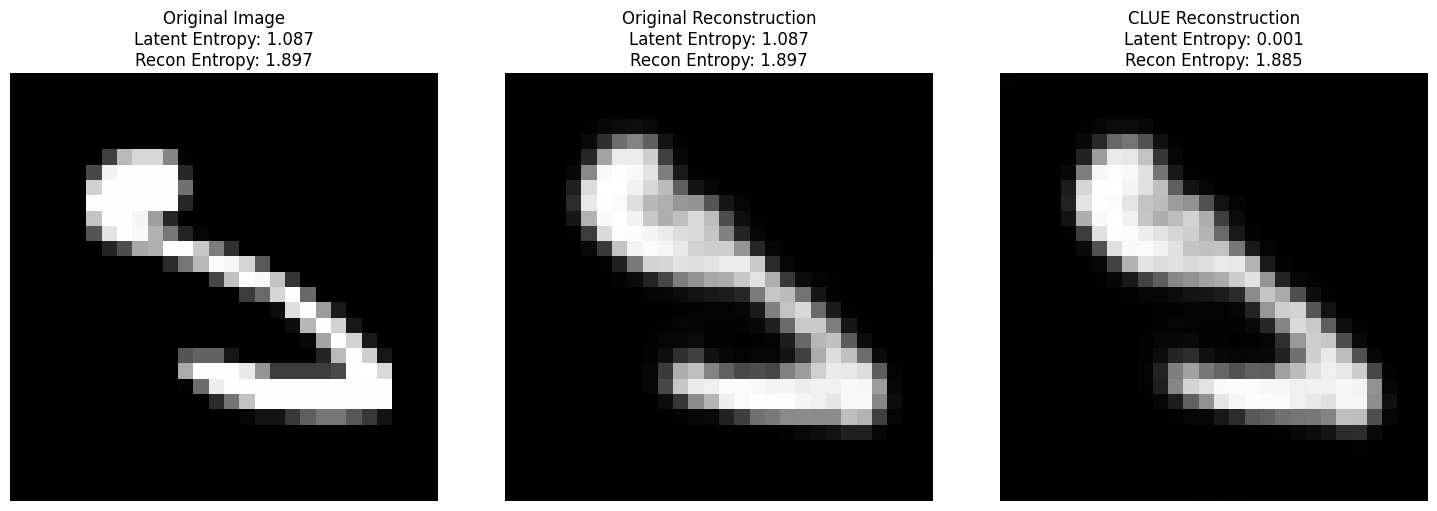

In [24]:
# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[4]
uncertain_image, _ = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
classifier.eval()
with torch.no_grad():
    z0, _ = classifier(uncertain_image)

# Initialize CLUE
clue = new_CLUE.NewCLUE(
    classifier=classifier.classifier,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.01,
    lr=0.1,
    device=device
)

# Optimize to find explanation
z_explained = clue.optimize(steps=50)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = decoder(z0)
    # CLUE reconstruction  
    clue_recon = decoder(z_explained)
    
    # Get predictions and uncertainties from latent codes
    original_logits_latent = classifier.classifier(z0)
    explained_logits_latent = classifier.classifier(z_explained)
    
    # Get predictions from full classifier workflow on reconstructions
    _, original_logits_recon = classifier(original_recon)
    _, explained_logits_recon = classifier(clue_recon)
    
    # Calculate probabilities and entropies for latent predictions
    original_probs_latent = torch.nn.functional.softmax(original_logits_latent, dim=1)
    explained_probs_latent = torch.nn.functional.softmax(explained_logits_latent, dim=1)
    
    original_entropy_latent = -(original_probs_latent * torch.log(original_probs_latent + 1e-10)).sum()
    explained_entropy_latent = -(explained_probs_latent * torch.log(explained_probs_latent + 1e-10)).sum()
    
    # Calculate probabilities and entropies for reconstruction predictions
    original_probs_recon = torch.nn.functional.softmax(original_logits_recon, dim=1)
    explained_probs_recon = torch.nn.functional.softmax(explained_logits_recon, dim=1)
    
    original_entropy_recon = -(original_probs_recon * torch.log(original_probs_recon + 1e-10)).sum()
    explained_entropy_recon = -(explained_probs_recon * torch.log(explained_probs_recon + 1e-10)).sum()

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nLatent Entropy: {original_entropy_latent:.3f}\nRecon Entropy: {original_entropy_recon:.3f}')
plt.axis('off')

plt.subplot(132)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Original Reconstruction\nLatent Entropy: {original_entropy_latent:.3f}\nRecon Entropy: {original_entropy_recon:.3f}')
plt.axis('off')

plt.subplot(133)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'CLUE Reconstruction\nLatent Entropy: {explained_entropy_latent:.3f}\nRecon Entropy: {explained_entropy_recon:.3f}')
plt.axis('off')

plt.tight_layout()
plt.show()


So we see that, while the entropy of the optimised latent code is near zero, the reconstuction looks identical to the original recosntruction of the test image. Indeed, passing the _reconstructed_ image through the entire classification pipeline (encoder -> classification head) results in almost the same entropy as before. It seems that the latent point is adversarial, and gets project back to the original in-distribution image.

Below, we plot the t-SNE of the latent space of the test set. We can see that the optimised latent code is close to the original latent code, but not identical.


Distance between original and explained points in t-SNE space: 0.117


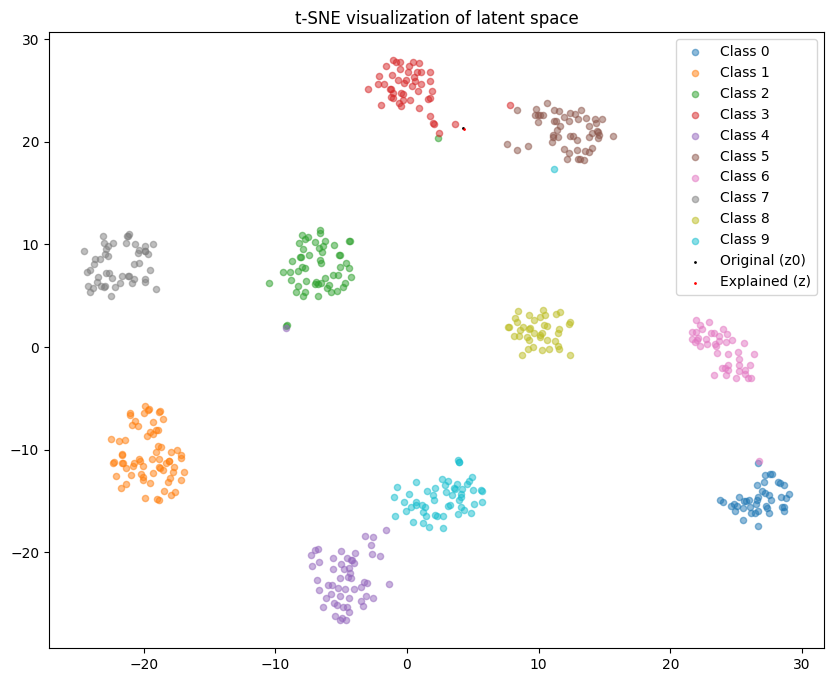

In [25]:
# Get latent codes for 500 training images to create TSNE visualization
latent_codes = []
labels_list = []
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        if i >= 500/images.shape[0]:  # Stop after ~500 images
            break
        images = images.to(device)
        z, _ = classifier(images)
        latent_codes.append(z.cpu())
        labels_list.append(labels)
latent_codes = torch.cat(latent_codes, dim=0)
labels = torch.cat(labels_list, dim=0)

# Add z0 and z_explained to the latent codes
all_latents = torch.cat([latent_codes, z0.cpu(), z_explained.cpu()], dim=0)

# Perform t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(all_latents.numpy())

# Plot t-SNE
plt.figure(figsize=(10, 8))

# Create scatter plot for each class
testing_latents_2d = latents_2d[:-2]
for i in range(10):
    mask = labels == i
    plt.scatter(testing_latents_2d[mask, 0], testing_latents_2d[mask, 1], 
               alpha=0.5, label=f'Class {i}', s=20)  # Reduced point size to 20

# Plot original and explained points
plt.scatter(latents_2d[-2, 0], latents_2d[-2, 1], c='black', s=1, label='Original (z0)')
plt.scatter(latents_2d[-1, 0], latents_2d[-1, 1], c='red', s=1, label='Explained (z)')
plt.plot([latents_2d[-2, 0], latents_2d[-1, 0]], 
         [latents_2d[-2, 1], latents_2d[-1, 1]], 
         'k--', alpha=0.5)

# Calculate and print distance between original and explained points in t-SNE space
tsne_distance = np.sqrt(np.sum((latents_2d[-2] - latents_2d[-1])**2))
print(f"\nDistance between original and explained points in t-SNE space: {tsne_distance:.3f}")

plt.title('t-SNE visualization of latent space')
plt.legend()
plt.show()


## Testing CLUE on the SVAE
Let's see if we can improve on the previous results by using the SVAE.

### Load the SVAE and prepare data for testing

In [57]:
from importlib import reload
import models.SVAE as SVAE
reload(SVAE)
from models.SVAE import SVAE

svae = SVAE(latent_dim=latent_dim, num_classes=10, device=device)
svae.load_state_dict(torch.load(os.path.join(model_saves_dir, 'svae.pth'), map_location=device))

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_13985/2699334937.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  svae.load_state_dict(torch.load(os.path.join(

<All keys matched successfully>

Test the model on some images

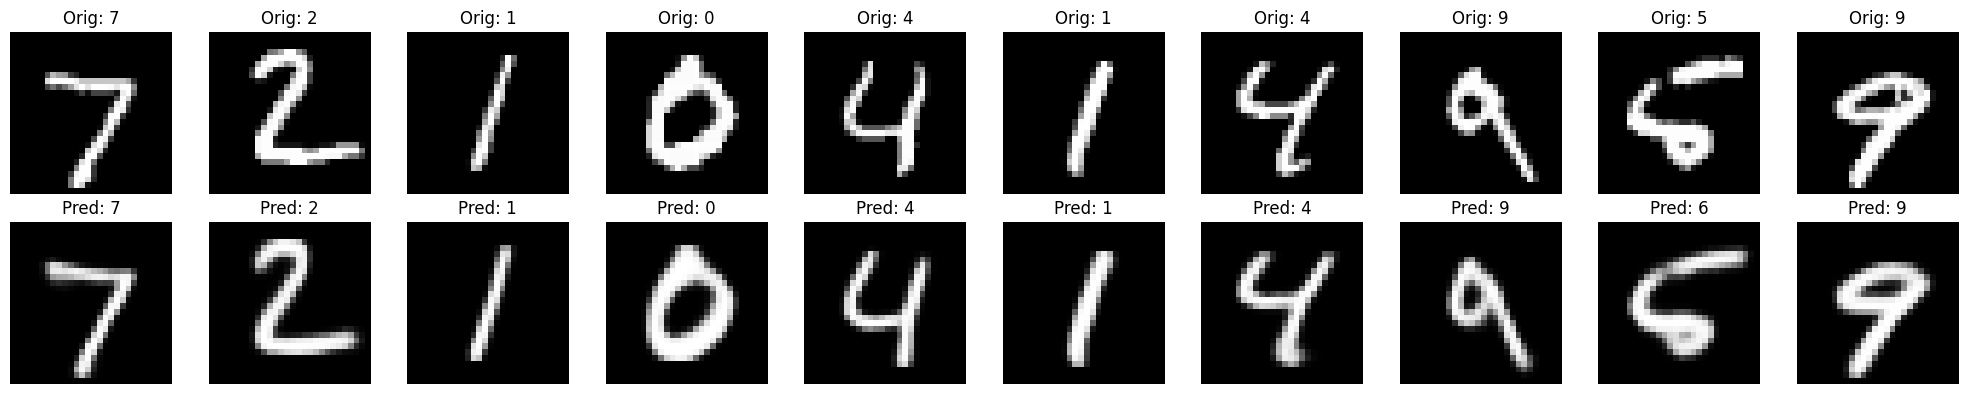

In [58]:
# Get a batch of images from the testloader
svae.eval()
with torch.no_grad():
    # Get one batch of images
    images, labels = next(iter(testloader))
    images = images.to(device)
    labels = labels.to(device)
    
    # Pass through SVAE
    recon_images, pred_labels, mu, log_var = svae(images)
    
    # Get predictions
    pred_classes = torch.argmax(pred_labels, dim=1)

# Plot the results
plt.figure(figsize=(20, 4))

# Plot original images
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f'Orig: {labels[i].item()}')
    plt.axis('off')

# Plot reconstructed images
for i in range(10):
    plt.subplot(2, 10, i+11)
    plt.imshow(recon_images[i].cpu().squeeze(), cmap='gray')
    plt.title(f'Pred: {pred_classes[i].item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Get the most uncertain images, we need a non-shuffled loader for this.

In [59]:
# Create a non-shuffled loader for uncertainty calculation
eval_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Get uncertainty scores for all test data points
uncertainties = []
indices = []

svae.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        # Get predictions from SVAE
        _, logits, _, _ = svae(images)
        
        # Calculate uncertainty (entropy) for each prediction
        probs = torch.nn.functional.softmax(logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        
        # Store uncertainties and indices
        uncertainties.extend(entropy.cpu().numpy())
        indices.extend(range(i*eval_loader.batch_size, min((i+1)*eval_loader.batch_size, len(trainset))))

# Convert to numpy arrays
uncertainties = np.array(uncertainties)
indices = np.array(indices)

# Sort by uncertainty (descending order)
sorted_idx = np.argsort(-uncertainties)
sorted_uncertainties_svae = uncertainties[sorted_idx]
sorted_data_indices_svae = indices[sorted_idx]

print(f"\nMost uncertain predictions have entropy: {sorted_uncertainties_svae[:5]}")
print(f"Least uncertain predictions have entropy: {sorted_uncertainties_svae[-5:]}")


Most uncertain predictions have entropy: [1.591673  1.4518467 1.3716214 1.3248947 1.315818 ]
Least uncertain predictions have entropy: [2.5849940e-07 2.1408985e-07 1.5443415e-07 1.2334432e-07 7.6232546e-08]


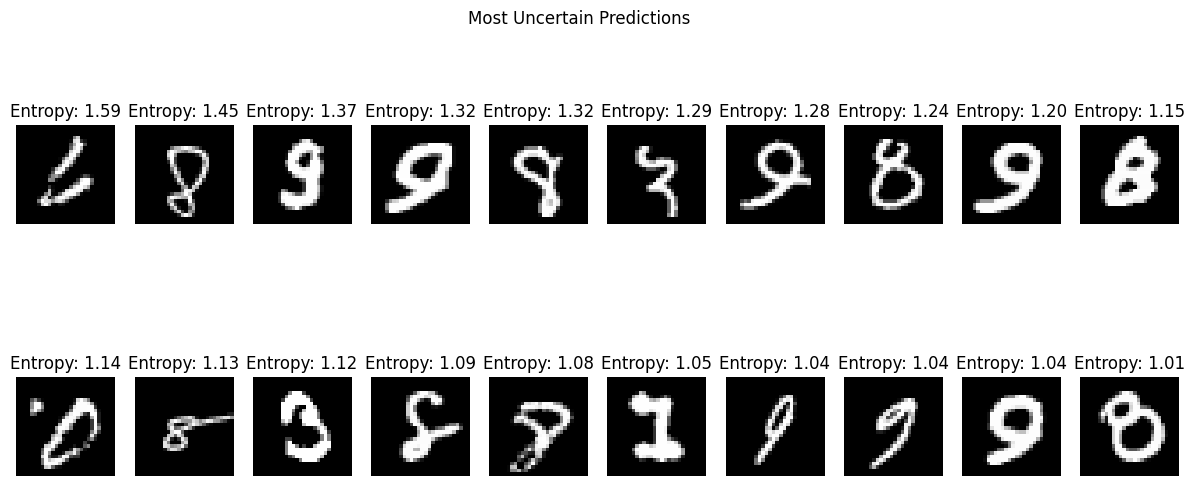

In [60]:
# Plot the most uncertain predictions
plot_most_uncertain(testset, sorted_data_indices_svae, sorted_uncertainties_svae, n_plot=20)
plt.show()


### Apply CLUE to SVAE

A single example of a counterfactual explanation

Step 00: Loss: 1.1954, Entropy: 1.1954, Distance: 0.0000
Step 01: Loss: 0.6392, Entropy: 0.6232, Distance: 1.6000
Step 02: Loss: 0.1856, Entropy: 0.1591, Distance: 2.6446
Step 03: Loss: 0.0623, Entropy: 0.0259, Distance: 3.6343
Step 04: Loss: 0.0497, Entropy: 0.0049, Distance: 4.4866
Step 05: Loss: 0.0531, Entropy: 0.0011, Distance: 5.1951
Step 06: Loss: 0.0581, Entropy: 0.0003, Distance: 5.7805
Step 07: Loss: 0.0627, Entropy: 0.0001, Distance: 6.2632
Step 08: Loss: 0.0666, Entropy: 0.0000, Distance: 6.6596
Step 09: Loss: 0.0698, Entropy: 0.0000, Distance: 6.9827
Step 10: Loss: 0.0724, Entropy: 0.0000, Distance: 7.2431
Step 11: Loss: 0.0745, Entropy: 0.0000, Distance: 7.4490
Step 12: Loss: 0.0761, Entropy: 0.0000, Distance: 7.6076
Step 13: Loss: 0.0773, Entropy: 0.0000, Distance: 7.7248
Step 14: Loss: 0.0781, Entropy: 0.0000, Distance: 7.8055
Step 15: Loss: 0.0785, Entropy: 0.0000, Distance: 7.8541
Step 16: Loss: 0.0787, Entropy: 0.0000, Distance: 7.8742
Step 17: Loss: 0.0787, Entropy:

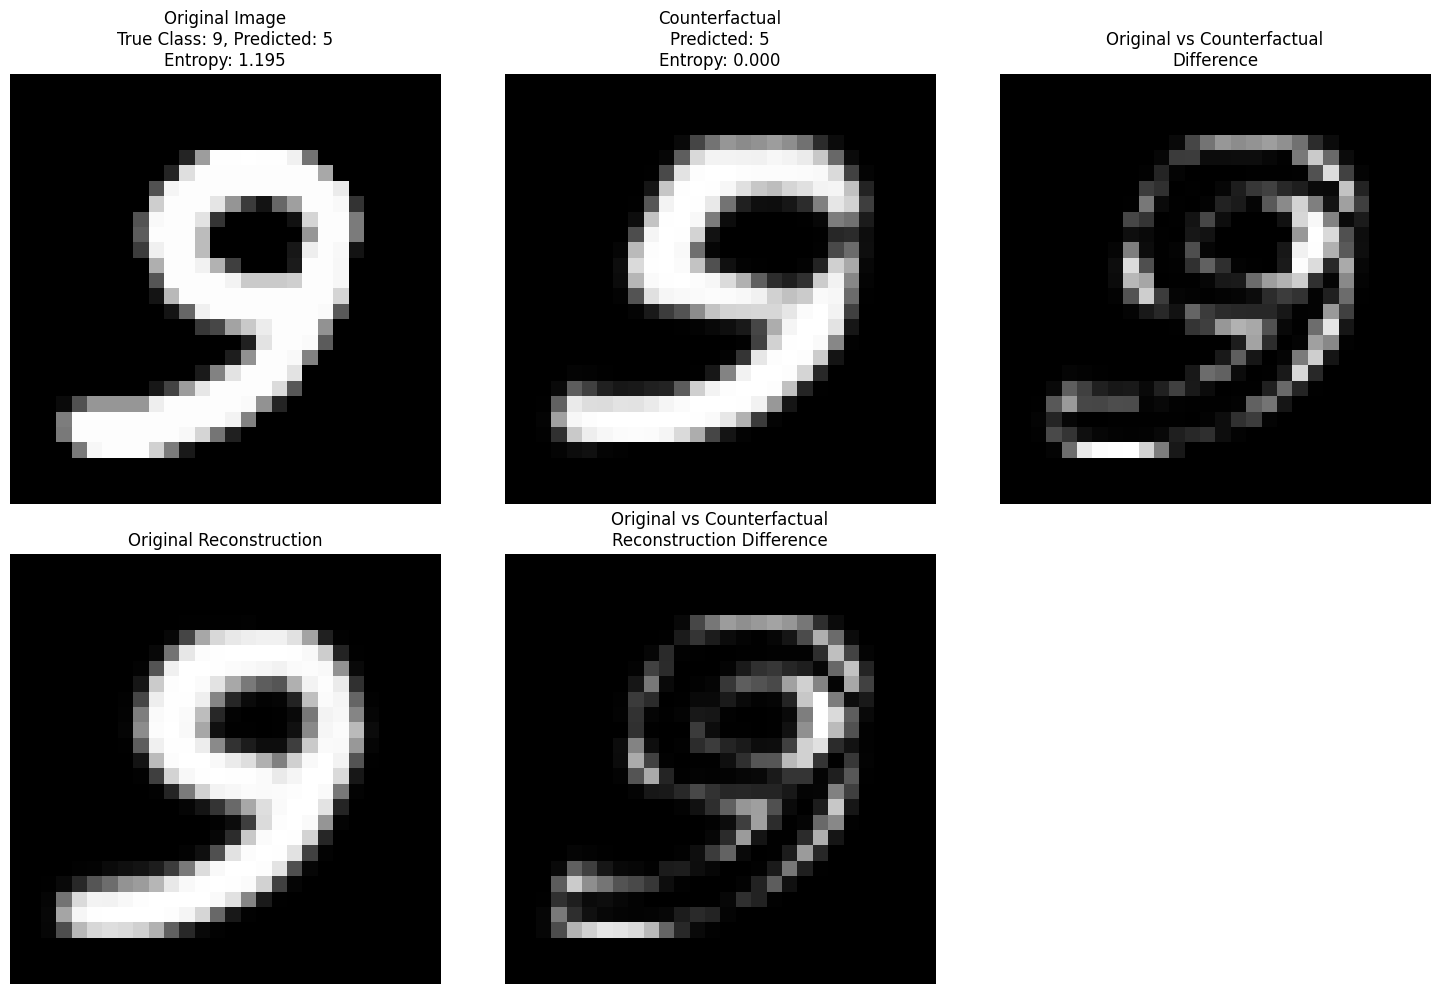


Class probabilities:
Original (True class: 9, Predicted: 5): [0.001 0.    0.003 0.157 0.    0.437 0.    0.    0.049 0.352]
Explained (Predicted: 5): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [66]:
# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices_svae[8]
uncertain_image, true_label = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
svae.eval()
with torch.no_grad():
    # We don't reparameterize here, we use the mean of the latent distribution. This is because this is what the classifier is trained on.
    _, _, z0, _ = svae(uncertain_image)

# Initialize CLUE
clue = new_CLUE.NewCLUE(
    classifier=svae.classifier,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.01,
    lr=0.1,
    device=device
)

# Optimize to find explanation
z_explained = clue.optimize(steps=50)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = svae.decode(z0)
    # CLUE reconstruction  
    clue_recon = svae.decode(z_explained)
    
    # Get predictions and uncertainties
    # Use only the classifier head for the latent vectors
    original_logits = svae.classifier(z0)
    explained_logits = svae.classifier(z_explained)
    
    original_probs = torch.nn.functional.softmax(original_logits, dim=1)
    explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
    
    original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
    explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()

    # Get predicted classes
    original_pred = torch.argmax(original_probs, dim=1).item()
    explained_pred = torch.argmax(explained_probs, dim=1).item()

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nTrue Class: {true_label}, Predicted: {original_pred}\nEntropy: {original_entropy:.3f}')
plt.axis('off')

plt.subplot(232)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Counterfactual\nPredicted: {explained_pred}\nEntropy: {explained_entropy:.3f}')
plt.axis('off')

plt.subplot(233)
plt.imshow(torch.abs(uncertain_image[0,0].cpu() - clue_recon[0,0].cpu().detach()), cmap='gray')
plt.title('Original vs Counterfactual\nDifference')
plt.axis('off')

plt.subplot(234)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(235)
plt.imshow(torch.abs(original_recon[0,0].cpu().detach() - clue_recon[0,0].cpu().detach()), cmap='gray')
plt.title('Original vs Counterfactual\nReconstruction Difference')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities
print("\nClass probabilities:")
print(f"Original (True class: {true_label}, Predicted: {original_pred}):", original_probs.cpu().numpy()[0].round(3))
print(f"Explained (Predicted: {explained_pred}):", explained_probs.cpu().numpy()[0].round(3))

It works! Much better than the joint-training autoencoder. Additionally, the counterfactual seems to be compelled to remain within the class of the original prediction (the index 8 is a good example of this. Intuitively, it looks like a 9, but the prediction is for a 5. Faithfully to the original prediction, the counterfactual is also a 5, showing the minimal changes required to product a more confident prediction of a 5.)

Let's explain the 20 most uncertain images in the test set.

Step 00: Loss: 1.5917, Entropy: 1.5917, Distance: 0.0000
Step 01: Loss: 0.9075, Entropy: 0.8755, Distance: 1.6000
Step 02: Loss: 0.5098, Entropy: 0.4528, Distance: 2.8518
Step 03: Loss: 0.1811, Entropy: 0.1045, Distance: 3.8308
Step 04: Loss: 0.1126, Entropy: 0.0178, Distance: 4.7378
Step 05: Loss: 0.1134, Entropy: 0.0035, Distance: 5.4932
Step 06: Loss: 0.1228, Entropy: 0.0009, Distance: 6.0998
Step 07: Loss: 0.1318, Entropy: 0.0003, Distance: 6.5787
Step 08: Loss: 0.1391, Entropy: 0.0001, Distance: 6.9507
Step 09: Loss: 0.1447, Entropy: 0.0000, Distance: 7.2326
Step 10: Loss: 0.1488, Entropy: 0.0000, Distance: 7.4383
Step 11: Loss: 0.1516, Entropy: 0.0000, Distance: 7.5792
Step 12: Loss: 0.1533, Entropy: 0.0000, Distance: 7.6647
Step 13: Loss: 0.1541, Entropy: 0.0000, Distance: 7.7027
Step 14: Loss: 0.1540, Entropy: 0.0000, Distance: 7.6999
Step 15: Loss: 0.1532, Entropy: 0.0000, Distance: 7.6621
Step 16: Loss: 0.1519, Entropy: 0.0000, Distance: 7.5942
Step 17: Loss: 0.1500, Entropy:

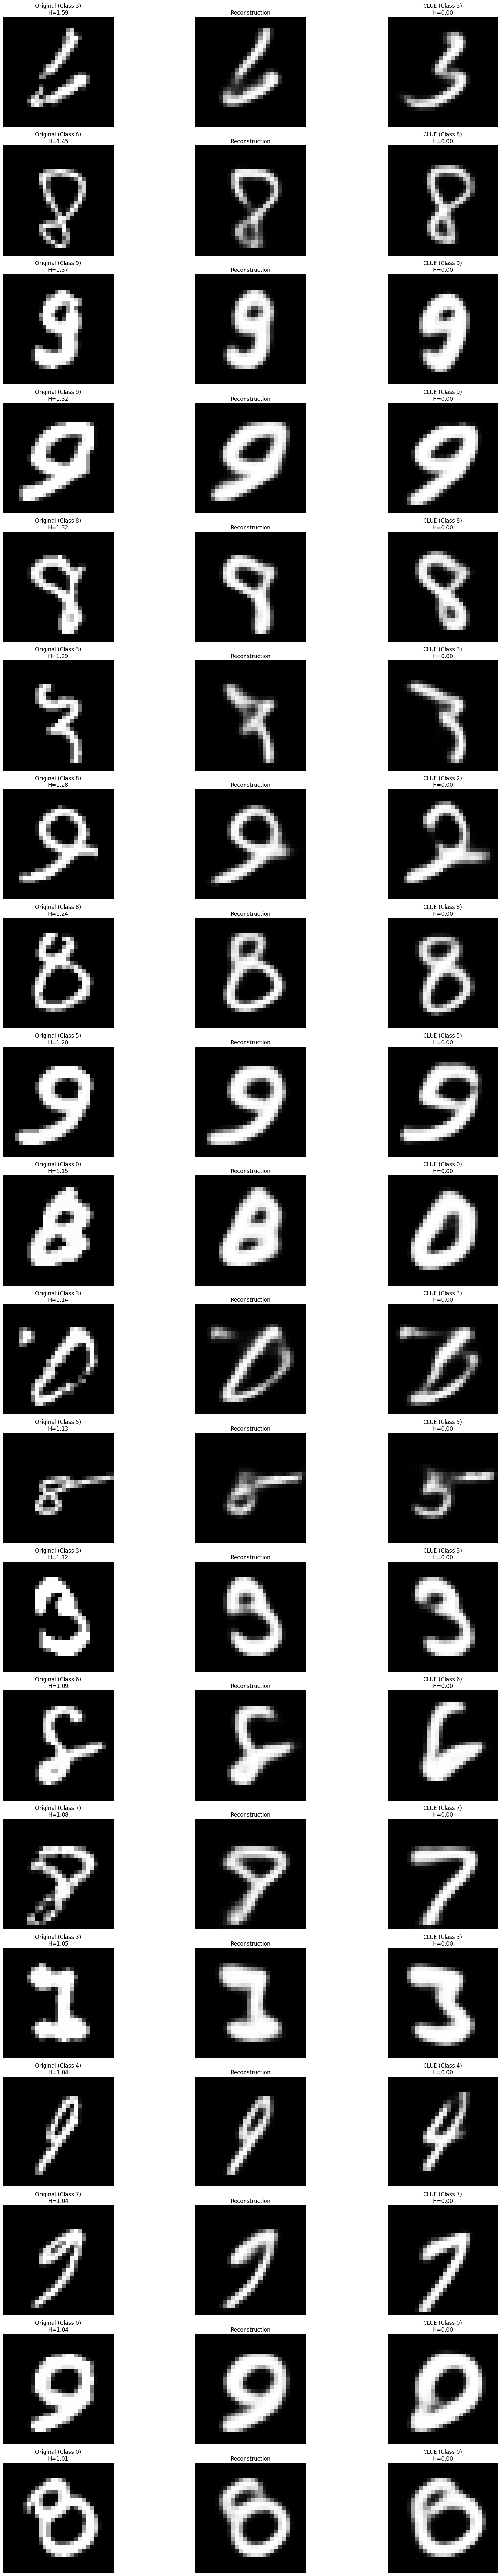


Class probabilities for last example:
Original (Class 0): [0.563 0.    0.    0.007 0.    0.079 0.017 0.    0.331 0.002]
Explained (Class 0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [65]:
# Get 20 most uncertain images and generate CLUEs for each
plt.figure(figsize=(20, 80))  # Increased height significantly to give more space per row

for i in range(20):
    # Get uncertain image and its latent representation 
    uncertain_idx = sorted_data_indices_svae[i]
    uncertain_image, _ = testset[uncertain_idx]
    uncertain_image = uncertain_image.to(device).unsqueeze(0)

    # Get latent representation
    svae.eval()
    with torch.no_grad():
        _, _, z0, _ = svae(uncertain_image)

    # Initialize and run CLUE
    clue = new_CLUE.SimpleCLUE(
        model=svae,
        z0=z0,
        uncertainty_weight=1.0,
        distance_weight=0.02,
        lr=0.1,
        device=device
    )
    z_explained = clue.optimize(steps=50)

    # Generate reconstructions
    with torch.no_grad():
        original_recon = svae.decode(z0)
        clue_recon = svae.decode(z_explained)
        
        # Get predictions and uncertainties
        original_logits = svae.classifier(z0)
        explained_logits = svae.classifier(z_explained)
        original_probs = torch.nn.functional.softmax(original_logits, dim=1)
        explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
        original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
        explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()
        
        # Get predicted classes
        original_class = torch.argmax(original_probs).item()
        explained_class = torch.argmax(explained_probs).item()

    # Plot this example
    plt.subplot(20, 3, 3*i+1)
    plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
    plt.title(f'Original (Class {original_class})\nH={original_entropy:.2f}', fontsize=12)
    plt.axis('off')

    plt.subplot(20, 3, 3*i+2)
    plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
    plt.title('Reconstruction', fontsize=12)
    plt.axis('off')

    plt.subplot(20, 3, 3*i+3)
    plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
    plt.title(f'CLUE (Class {explained_class})\nH={explained_entropy:.2f}', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities for last example
print("\nClass probabilities for last example:")
print("Original (Class {}):".format(original_class), original_probs.cpu().numpy()[0].round(3))
print("Explained (Class {}):".format(explained_class), explained_probs.cpu().numpy()[0].round(3))